# Complete Nuclear Risk Prediction Model

## Objective
**Predict `true_risk_level` (0, 1, 2, 3) using both XGBoost and Deep Learning**

## Contents
1. Data Loading & Exploration
2. Feature Engineering
3. Data Preparation
4. **XGBoost Model**
5. **Deep Learning Model**
6. **Final Comparison**

---

## Setup & Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, balanced_accuracy_score, cohen_kappa_score
)
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# XGBoost
import xgboost as xgb

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Setup complete!')
print(f'PyTorch device: {device}')
print(f'XGBoost version: {xgb.__version__}')
print(f'PyTorch version: {torch.__version__}')

Setup complete!
PyTorch device: cuda
XGBoost version: 3.1.1
PyTorch version: 2.9.0+cu130


---
## 1. Data Loading & Exploration

In [2]:
# Load data
df = pd.read_csv('avalon_nuclear.csv')

print('='*70)
print('DATASET OVERVIEW')
print('='*70)
print(f'Shape: {df.shape}')
print(f'\nTarget Variable: true_risk_level')
print(f'\nClass Distribution:')
print(df['true_risk_level'].value_counts().sort_index())
print(f'\nClass Proportions:')
print(df['true_risk_level'].value_counts(normalize=True).sort_index())
print(f'\nMissing Values: {df.isnull().sum().sum()}')

DATASET OVERVIEW
Shape: (5000, 37)

Target Variable: true_risk_level

Class Distribution:
true_risk_level
0     134
1     422
2     990
3    3454
Name: count, dtype: int64

Class Proportions:
true_risk_level
0    0.0268
1    0.0844
2    0.1980
3    0.6908
Name: proportion, dtype: float64

Missing Values: 0


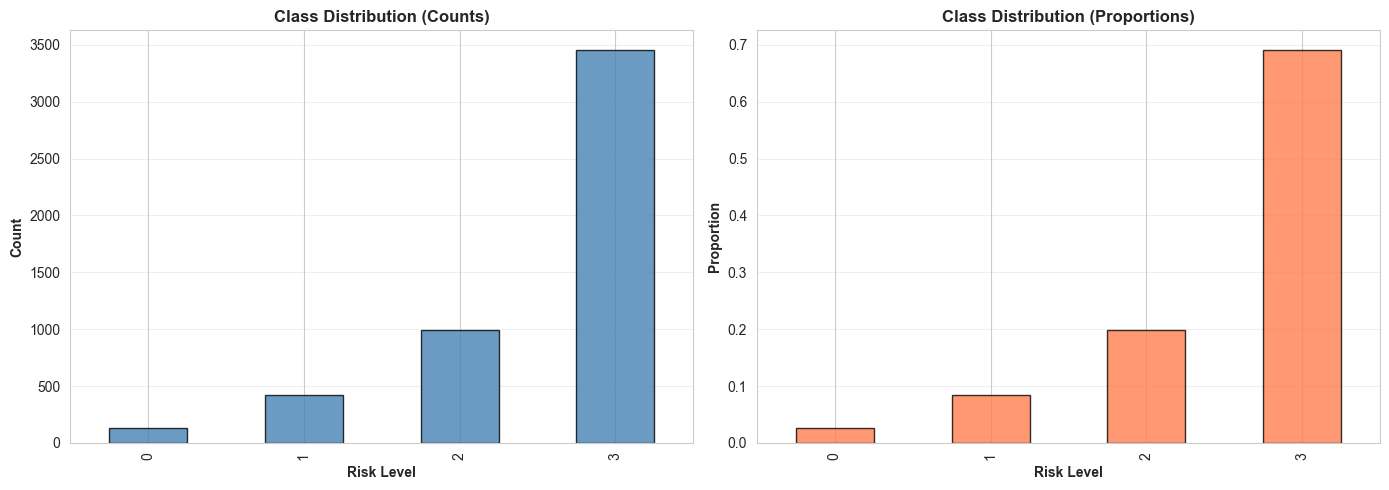

NOTE: Dataset is highly imbalanced - Risk Level 3 dominates (69%)


In [3]:
# Visualize class distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['true_risk_level'].value_counts().sort_index().plot(
    kind='bar', ax=ax[0], color='steelblue', alpha=0.8, edgecolor='black'
)
ax[0].set_title('Class Distribution (Counts)', fontweight='bold', fontsize=12)
ax[0].set_xlabel('Risk Level', fontweight='bold')
ax[0].set_ylabel('Count', fontweight='bold')
ax[0].grid(axis='y', alpha=0.3)

# Proportion plot
df['true_risk_level'].value_counts(normalize=True).sort_index().plot(
    kind='bar', ax=ax[1], color='coral', alpha=0.8, edgecolor='black'
)
ax[1].set_title('Class Distribution (Proportions)', fontweight='bold', fontsize=12)
ax[1].set_xlabel('Risk Level', fontweight='bold')
ax[1].set_ylabel('Proportion', fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('NOTE: Dataset is highly imbalanced - Risk Level 3 dominates (69%)')

---
## 2. Feature Engineering

Creating advanced features based on domain knowledge

In [4]:
print('Creating engineered features...')
df_model = df.copy()

# === PHYSICS-BASED FEATURES ===
df_model['thermal_stress'] = df_model['core_temp_c'] * df_model['coolant_pressure_bar'] / 1000
df_model['radiation_differential'] = df_model['radiation_inside_uSv'] - df_model['radiation_outside_uSv']
df_model['radiation_ratio'] = df_model['radiation_inside_uSv'] / (df_model['radiation_outside_uSv'] + 1)
df_model['coolant_efficiency'] = df_model['coolant_flow_rate'] / (df_model['core_temp_c'] + 1)
df_model['thermal_margin'] = 350 - df_model['core_temp_c']
df_model['control_effectiveness'] = (100 - df_model['control_rod_position_pct']) * df_model['neutron_flux'] / 100

# === OPERATIONAL RISK ===
df_model['age_power_risk'] = df_model['reactor_age_years'] / (df_model['reactor_nominal_power_mw'] + 1)
df_model['maintenance_risk'] = df_model['reactor_age_years'] * (100 - df_model['maintenance_score']) * df_model['days_since_maintenance'] / 10000
df_model['staff_risk'] = df_model['staff_fatigue_index'] * df_model['sensor_anomaly_flag']

# === SOCIAL/EXTERNAL ===
df_model['social_pressure'] = (
    df_model['public_anxiety_index'] * 0.4 +
    df_model['social_media_rumour_index'] * 0.3 +
    df_model['regulator_scrutiny_score'] * 0.3
)
df_model['external_threat'] = (
    df_model['weather_severity_index'] +
    df_model['seismic_activity_index'] +
    df_model['cyber_attack_score']
) / 3
df_model['population_risk'] = np.log1p(df_model['population_within_30km']) * df_model['radiation_inside_uSv'] / 100

# === COMPOSITE INDICES ===
df_model['physical_risk_index'] = (
    (df_model['core_temp_c'] / 350) * 0.35 +
    (df_model['coolant_pressure_bar'] / 160) * 0.25 +
    (df_model['radiation_inside_uSv'] / 1000) * 0.25 +
    (df_model['neutron_flux'] / 5) * 0.15
)
df_model['operational_risk_index'] = (
    (df_model['reactor_age_years'] / 60) * 0.3 +
    ((100 - df_model['maintenance_score']) / 100) * 0.3 +
    (df_model['staff_fatigue_index'] / 100) * 0.2 +
    (df_model['sensor_anomaly_flag']) * 0.2
)

# === AVALON BIAS ===
df_model['avalon_bias'] = df_model['avalon_raw_risk_score'] - (df_model['physical_risk_index'] * 100)
df_model['avalon_confidence'] = 100 - abs(df_model['avalon_raw_risk_score'] - df_model['avalon_learned_reward_score'])

# === INTERACTIONS ===
df_model['temp_age_interaction'] = df_model['core_temp_c'] * df_model['reactor_age_years'] / 100
df_model['pressure_flow_interaction'] = df_model['coolant_pressure_bar'] * df_model['coolant_flow_rate'] / 100

# === POLYNOMIAL ===
df_model['core_temp_squared'] = df_model['core_temp_c'] ** 2
df_model['pressure_squared'] = df_model['coolant_pressure_bar'] ** 2
df_model['radiation_log'] = np.log1p(df_model['radiation_inside_uSv'])

print(f'Original features: {df.shape[1]}')
print(f'After engineering: {df_model.shape[1]}')
print(f'New features added: {df_model.shape[1] - df.shape[1]}')

Creating engineered features...
Original features: 37
After engineering: 58
New features added: 21


---
## 3. Data Preparation

In [5]:
# Encode categorical
le = LabelEncoder()
df_model['country_encoded'] = le.fit_transform(df_model['country'])

# Define features (exclude target and future leakage)
exclude_cols = [
    'country',
    'true_risk_level',  # TARGET
    'incident_occurred',  # Future information
    'avalon_evac_recommendation',
    'avalon_shutdown_recommendation',
    'human_override'
]

feature_cols = [col for col in df_model.columns if col not in exclude_cols]
X = df_model[feature_cols].values
y = df_model['true_risk_level'].values

print(f'Feature matrix shape: {X.shape}')
print(f'Total features: {len(feature_cols)}')
print(f'Target shape: {y.shape}')

Feature matrix shape: (5000, 53)
Total features: 53
Target shape: (5000,)


In [6]:
# Split data
# For XGBoost: 80/20 train/test
# For Deep Learning: 60/20/20 train/val/test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print('Data Split:')
print(f'  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)')
print(f'  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)')

# For XGBoost: use train+val as training set
X_train_xgb = np.vstack([X_train, X_val])
y_train_xgb = np.concatenate([y_train, y_val])
print(f'\nXGBoost training set: {X_train_xgb.shape[0]} samples')

Data Split:
  Train: 3000 samples (60.0%)
  Val:   1000 samples (20.0%)
  Test:  1000 samples (20.0%)

XGBoost training set: 4000 samples


In [7]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_xgb_scaled = scaler.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler.transform(X_test)

print('Feature scaling complete (StandardScaler)')

Feature scaling complete (StandardScaler)


---
---
# PART 1: XGBoost Model
---
---

## 4. XGBoost - Hyperparameter Optimization

In [8]:
print('='*70)
print('XGBOOST MODEL TRAINING')
print('='*70)

# Compute sample weights for class imbalance
sample_weights = compute_sample_weight('balanced', y_train_xgb)
print(f'Sample weights computed for {len(np.unique(y_train_xgb))} classes')
print(f'Weight range: {sample_weights.min():.2f} - {sample_weights.max():.2f}')

XGBOOST MODEL TRAINING
Sample weights computed for 4 classes
Weight range: 0.36 - 9.35


In [9]:
# Hyperparameter search
print('\nStarting hyperparameter optimization...')
print('This may take a few minutes...\n')

param_dist = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 2, 3]
}

xgb_base = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_xgb_scaled, y_train_xgb, sample_weight=sample_weights)

print(f'\nBest CV Score (Balanced Accuracy): {random_search.best_score_:.4f}')
print('\nBest Parameters:')
for param, value in sorted(random_search.best_params_.items()):
    print(f'  {param:20s}: {value}')


Starting hyperparameter optimization...
This may take a few minutes...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best CV Score (Balanced Accuracy): 0.7143

Best Parameters:
  colsample_bytree    : 0.7
  gamma               : 0
  learning_rate       : 0.05
  max_depth           : 4
  min_child_weight    : 1
  n_estimators        : 300
  reg_alpha           : 0.5
  reg_lambda          : 3
  subsample           : 0.8


In [10]:
# Train final model with best parameters
xgb_model = random_search.best_estimator_
xgb_model.set_params(early_stopping_rounds=20)

xgb_model.fit(
    X_train_xgb_scaled, y_train_xgb,
    sample_weight=sample_weights,
    eval_set=[(X_train_xgb_scaled, y_train_xgb), (X_test_xgb_scaled, y_test)],
    verbose=False
)

print(f'XGBoost training complete!')
print(f'Best iteration: {xgb_model.best_iteration}')

XGBoost training complete!
Best iteration: 299


## XGBoost - Evaluation

In [11]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test_xgb_scaled)

# Metrics
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_bal_acc = balanced_accuracy_score(y_test, y_pred_xgb)
xgb_f1_weighted = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_f1_macro = f1_score(y_test, y_pred_xgb, average='macro')
xgb_kappa = cohen_kappa_score(y_test, y_pred_xgb)

print('='*70)
print('XGBOOST MODEL RESULTS')
print('='*70)
print(f'Accuracy:            {xgb_acc:.4f} ({xgb_acc*100:.2f}%)')
print(f'Balanced Accuracy:   {xgb_bal_acc:.4f} ({xgb_bal_acc*100:.2f}%)')
print(f'Weighted F1:         {xgb_f1_weighted:.4f}')
print(f'Macro F1:            {xgb_f1_macro:.4f}')
print(f'Cohen\'s Kappa:       {xgb_kappa:.4f}')

print('\n' + '='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(
    y_test, y_pred_xgb,
    target_names=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
    digits=4
))

XGBOOST MODEL RESULTS
Accuracy:            0.8320 (83.20%)
Balanced Accuracy:   0.7202 (72.02%)
Weighted F1:         0.8380
Macro F1:            0.7248
Cohen's Kappa:       0.6613

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Risk 0     0.8421    0.5926    0.6957        27
      Risk 1     0.5859    0.6905    0.6339        84
      Risk 2     0.5991    0.7020    0.6465       198
      Risk 3     0.9523    0.8958    0.9232       691

    accuracy                         0.8320      1000
   macro avg     0.7449    0.7202    0.7248      1000
weighted avg     0.8486    0.8320    0.8380      1000



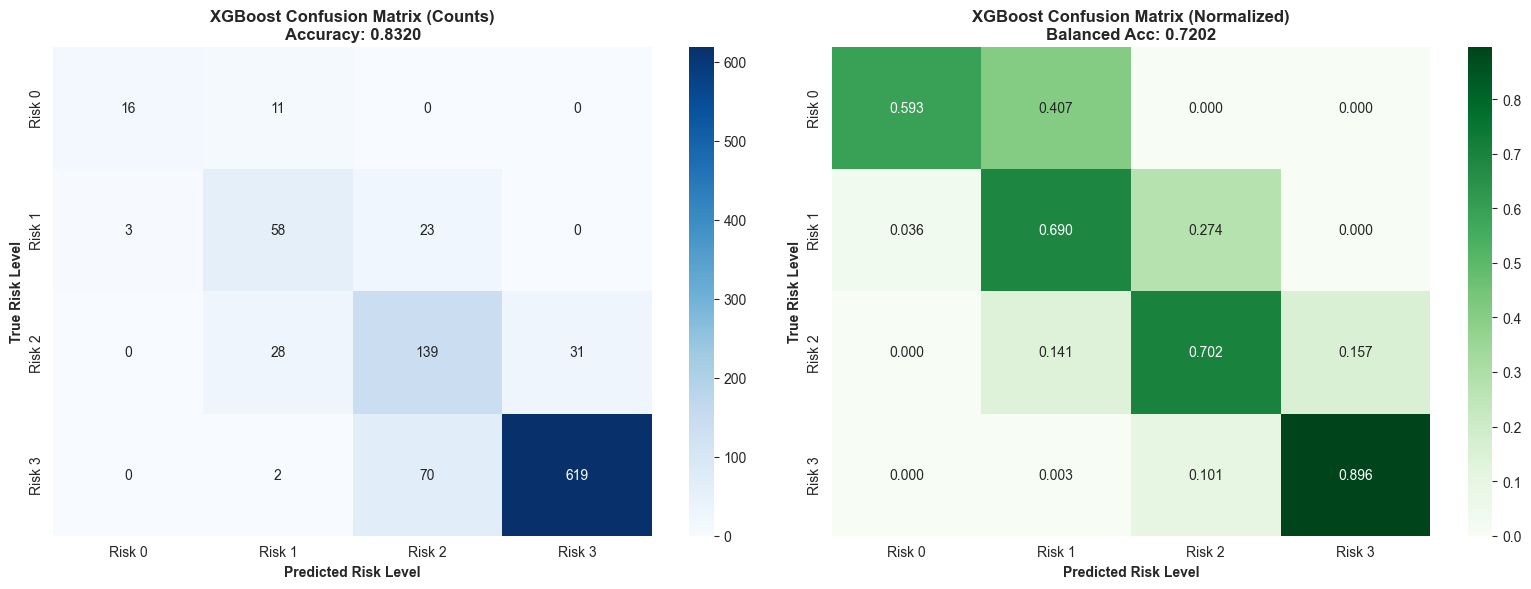

In [12]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'])
axes[0].set_title(f'XGBoost Confusion Matrix (Counts)\nAccuracy: {xgb_acc:.4f}',
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Risk Level', fontweight='bold')
axes[0].set_xlabel('Predicted Risk Level', fontweight='bold')

# Normalized
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_xgb_norm, annot=True, fmt='.3f', cmap='Greens', ax=axes[1],
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'])
axes[1].set_title(f'XGBoost Confusion Matrix (Normalized)\nBalanced Acc: {xgb_bal_acc:.4f}',
                  fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Risk Level', fontweight='bold')
axes[1].set_xlabel('Predicted Risk Level', fontweight='bold')

plt.tight_layout()
plt.show()

---
---
# PART 2: Deep Learning Model
---
---

## 5. Deep Learning - Model Architecture

In [13]:
# PyTorch Dataset
class RiskDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = RiskDataset(X_train_scaled, y_train)
val_dataset = RiskDataset(X_val_scaled, y_val)
test_dataset = RiskDataset(X_test_scaled, y_test)

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'DataLoaders created (batch_size={batch_size})')

DataLoaders created (batch_size=128)


In [14]:
# Neural Network Architecture
class DeepRiskModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.4):
        super(DeepRiskModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, 4)  # 4 risk levels
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create model
input_dim = X_train_scaled.shape[1]
dl_model = DeepRiskModel(input_dim, hidden_dims=[512, 256, 128], dropout=0.4).to(device)

print('='*70)
print('DEEP LEARNING MODEL')
print('='*70)
print(f'Architecture: {input_dim} -> 512 -> 256 -> 128 -> 4')
print(f'Parameters: {sum(p.numel() for p in dl_model.parameters()):,}')
print(f'Device: {device}')

DEEP LEARNING MODEL
Architecture: 53 -> 512 -> 256 -> 128 -> 4
Parameters: 194,180
Device: cuda


## Deep Learning - Training

In [15]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f'Class weights: {class_weights.cpu().numpy()}')

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(dl_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Class weights: [9.375     2.952756  1.2626263 0.3619691]


In [16]:
# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += predicted.eq(y_batch).sum().item()
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), accuracy, np.array(all_preds), np.array(all_labels)

print('Training functions defined')

Training functions defined


In [17]:
# Training loop
print('\nTraining Deep Learning model...\n')

epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(dl_model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(dl_model, val_loader, criterion)
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1:3d}/{epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(dl_model.state_dict(), 'best_dl_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break

# Load best model
dl_model.load_state_dict(torch.load('best_dl_model.pth'))
print('\nTraining complete! Best model loaded.')


Training Deep Learning model...

Epoch [ 10/100] - Train Loss: 0.5294, Train Acc: 0.8283 | Val Loss: 0.5368, Val Acc: 0.8000
Epoch [ 20/100] - Train Loss: 0.3741, Train Acc: 0.8660 | Val Loss: 0.5816, Val Acc: 0.8090

Early stopping at epoch 24

Training complete! Best model loaded.


## Deep Learning - Evaluation

In [18]:
# Evaluate on test set
test_loss, test_acc, y_pred_dl, y_true_dl = evaluate(dl_model, test_loader, criterion)

# Metrics
dl_acc = accuracy_score(y_true_dl, y_pred_dl)
dl_bal_acc = balanced_accuracy_score(y_true_dl, y_pred_dl)
dl_f1_weighted = f1_score(y_true_dl, y_pred_dl, average='weighted')
dl_f1_macro = f1_score(y_true_dl, y_pred_dl, average='macro')
dl_kappa = cohen_kappa_score(y_true_dl, y_pred_dl)

print('='*70)
print('DEEP LEARNING MODEL RESULTS')
print('='*70)
print(f'Accuracy:            {dl_acc:.4f} ({dl_acc*100:.2f}%)')
print(f'Balanced Accuracy:   {dl_bal_acc:.4f} ({dl_bal_acc*100:.2f}%)')
print(f'Weighted F1:         {dl_f1_weighted:.4f}')
print(f'Macro F1:            {dl_f1_macro:.4f}')
print(f'Cohen\'s Kappa:       {dl_kappa:.4f}')

print('\n' + '='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(
    y_true_dl, y_pred_dl,
    target_names=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
    digits=4
))

DEEP LEARNING MODEL RESULTS
Accuracy:            0.8130 (81.30%)
Balanced Accuracy:   0.7561 (75.61%)
Weighted F1:         0.8261
Macro F1:            0.7152
Cohen's Kappa:       0.6450

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Risk 0     0.6552    0.7037    0.6786        27
      Risk 1     0.5660    0.7143    0.6316        84
      Risk 2     0.5551    0.7626    0.6426       198
      Risk 3     0.9831    0.8437    0.9081       691

    accuracy                         0.8130      1000
   macro avg     0.6899    0.7561    0.7152      1000
weighted avg     0.8545    0.8130    0.8261      1000



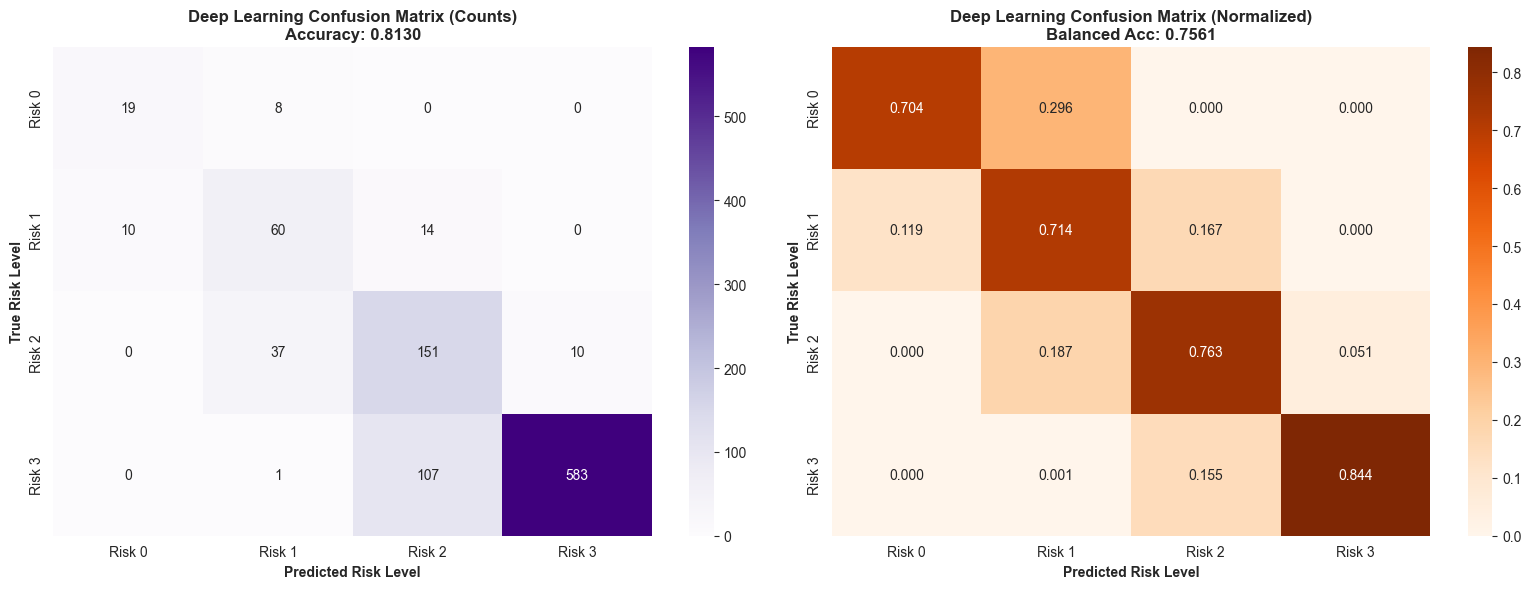

In [19]:
# Confusion Matrix
cm_dl = confusion_matrix(y_true_dl, y_pred_dl)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'])
axes[0].set_title(f'Deep Learning Confusion Matrix (Counts)\nAccuracy: {dl_acc:.4f}',
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Risk Level', fontweight='bold')
axes[0].set_xlabel('Predicted Risk Level', fontweight='bold')

# Normalized
cm_dl_norm = cm_dl.astype('float') / cm_dl.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_dl_norm, annot=True, fmt='.3f', cmap='Oranges', ax=axes[1],
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'])
axes[1].set_title(f'Deep Learning Confusion Matrix (Normalized)\nBalanced Acc: {dl_bal_acc:.4f}',
                  fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Risk Level', fontweight='bold')
axes[1].set_xlabel('Predicted Risk Level', fontweight='bold')

plt.tight_layout()
plt.show()

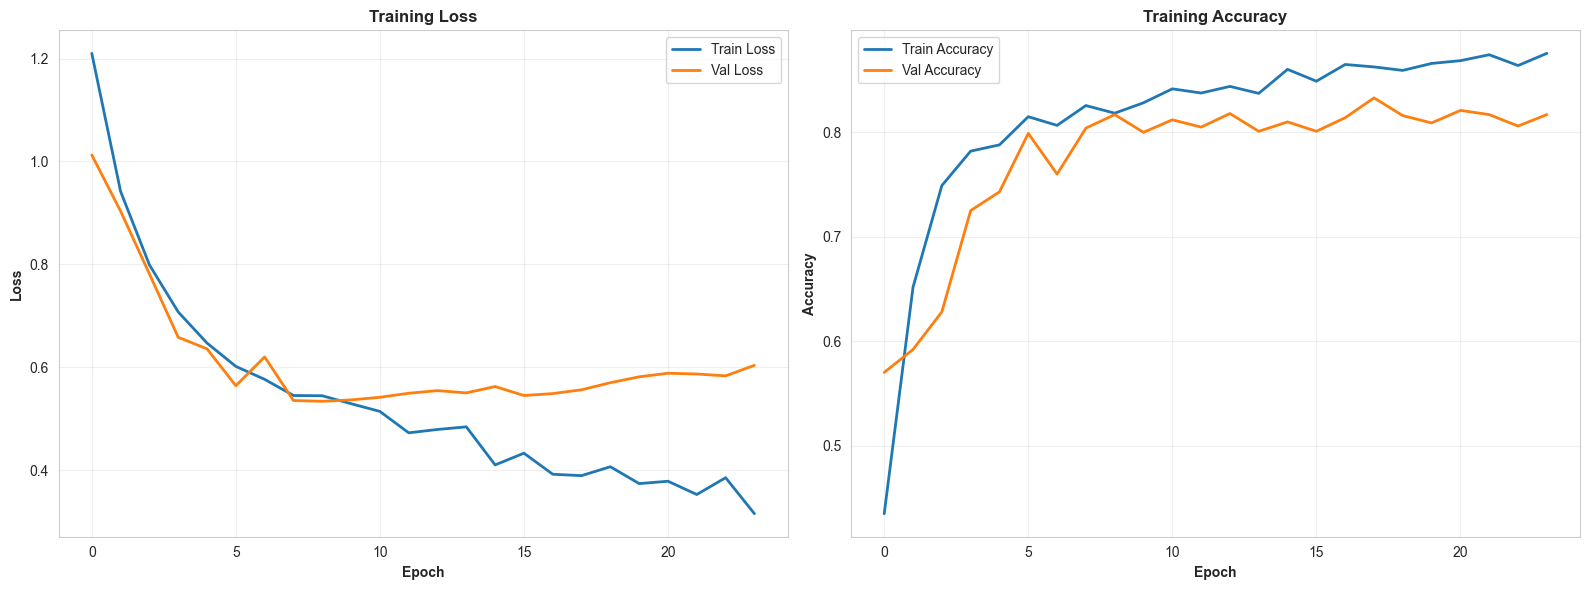

In [20]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('Training Loss', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Training Accuracy', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
---
# PART 3: Final Comparison
---
---

## 6. XGBoost vs Deep Learning Comparison

In [21]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['XGBoost', 'Deep Learning'],
    'Accuracy': [xgb_acc, dl_acc],
    'Balanced Accuracy': [xgb_bal_acc, dl_bal_acc],
    'Weighted F1': [xgb_f1_weighted, dl_f1_weighted],
    'Macro F1': [xgb_f1_macro, dl_f1_macro],
    'Cohen\'s Kappa': [xgb_kappa, dl_kappa]
})

print('='*80)
print('FINAL MODEL COMPARISON - true_risk_level PREDICTION')
print('='*80)
print(comparison.to_string(index=False))

# Determine winner
best_model = 'XGBoost' if xgb_bal_acc > dl_bal_acc else 'Deep Learning'
print(f'\nBest Model (by Balanced Accuracy): {best_model}')

if best_model == 'XGBoost':
    improvement = (xgb_bal_acc - dl_bal_acc) * 100
    print(f'XGBoost outperforms Deep Learning by {improvement:.2f} percentage points')
else:
    improvement = (dl_bal_acc - xgb_bal_acc) * 100
    print(f'Deep Learning outperforms XGBoost by {improvement:.2f} percentage points')

FINAL MODEL COMPARISON - true_risk_level PREDICTION
        Model  Accuracy  Balanced Accuracy  Weighted F1  Macro F1  Cohen's Kappa
      XGBoost     0.832           0.720223     0.837963  0.724809       0.661348
Deep Learning     0.813           0.756080     0.826096  0.715201       0.644955

Best Model (by Balanced Accuracy): Deep Learning
Deep Learning outperforms XGBoost by 3.59 percentage points


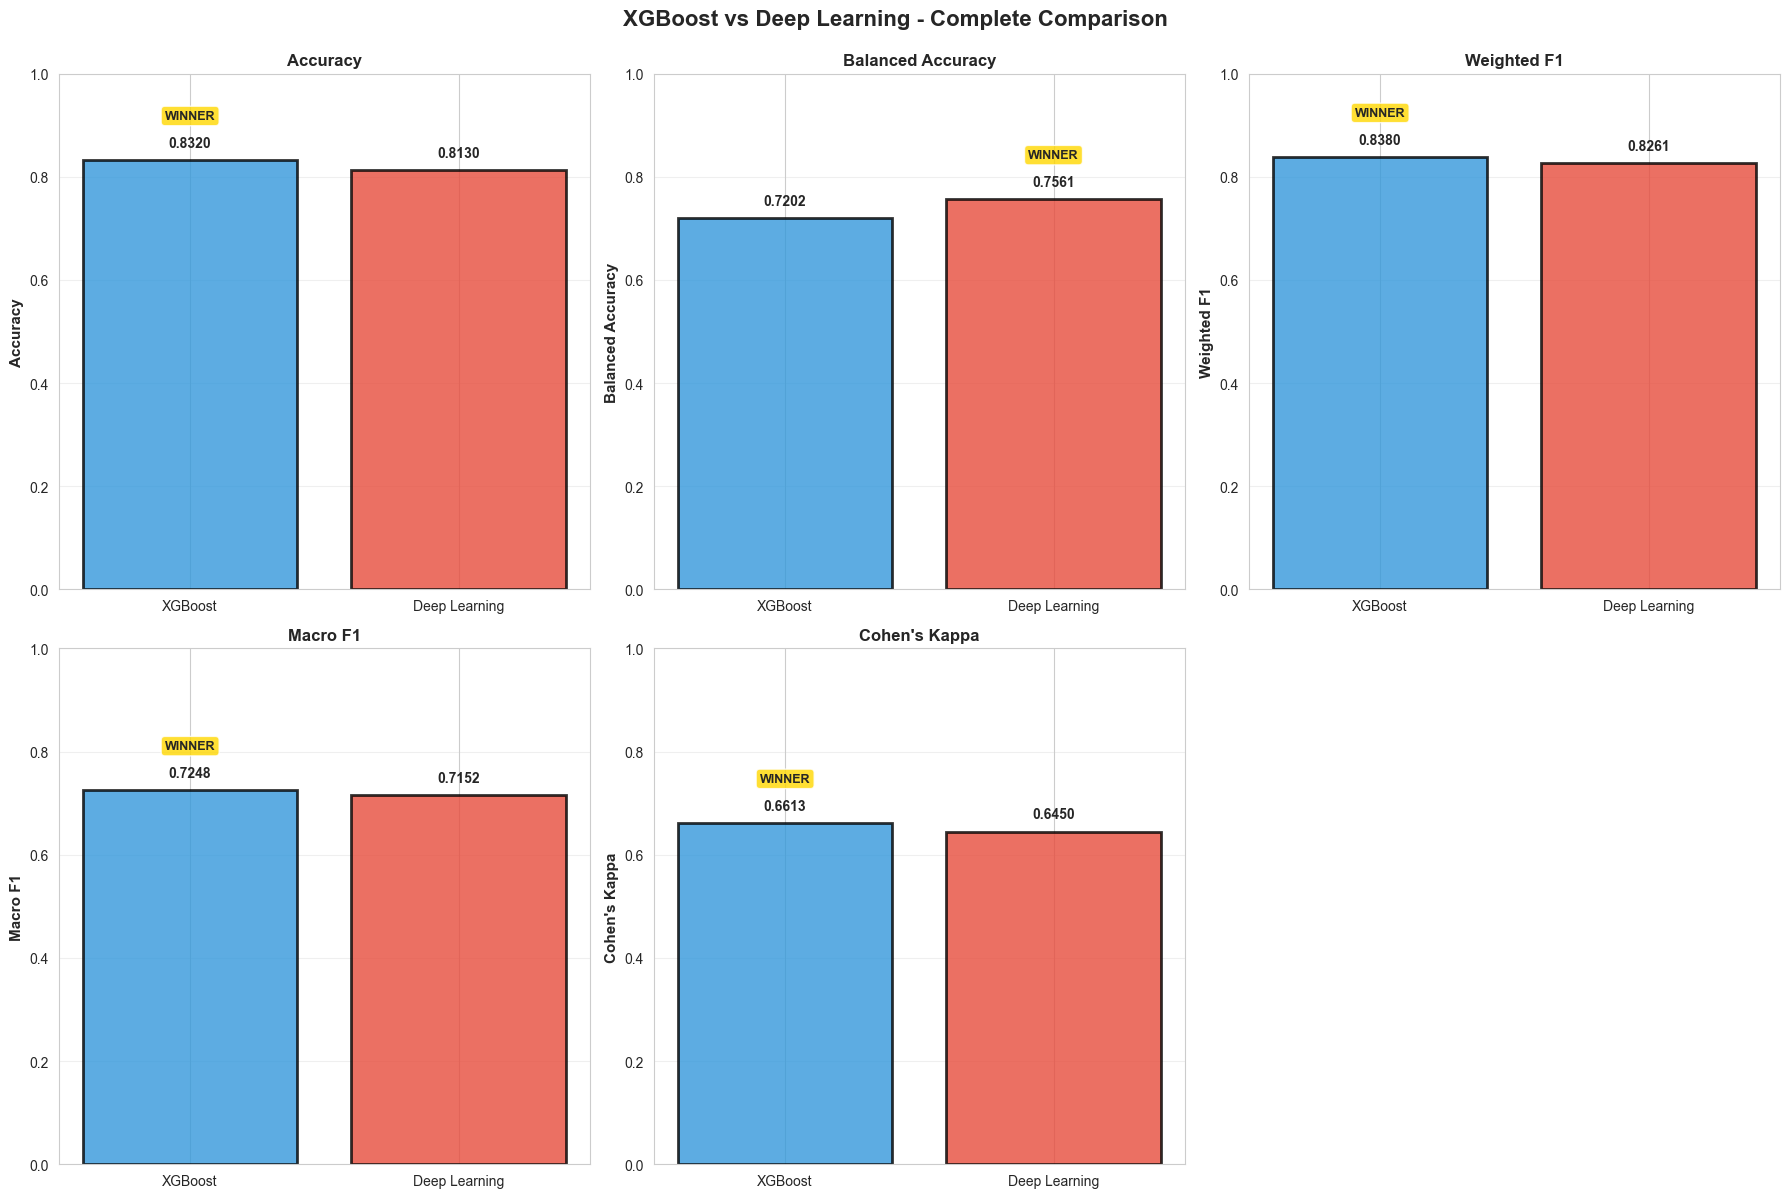

In [22]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics = ['Accuracy', 'Balanced Accuracy', 'Weighted F1', 'Macro F1', 'Cohen\'s Kappa']
colors = ['#3498DB', '#E74C3C']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison[metric].values
    bars = ax.bar(comparison['Model'], values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    ax.set_ylabel(metric, fontweight='bold', fontsize=11)
    ax.set_title(f'{metric}', fontweight='bold', fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Highlight winner
    winner_idx = np.argmax(values)
    ax.text(winner_idx, values[winner_idx] + 0.08, 'WINNER', ha='center',
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8))

# Remove extra subplot
axes[1, 2].axis('off')

plt.suptitle('XGBoost vs Deep Learning - Complete Comparison', 
             fontweight='bold', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Summary & Conclusions

In [23]:
print('='*80)
print('FINAL SUMMARY - NUCLEAR RISK LEVEL PREDICTION')
print('='*80)

print('\n[TASK]')
print('  Predict: true_risk_level (4 classes: 0, 1, 2, 3)')
print(f'  Dataset: {len(df)} samples, {len(feature_cols)} features')
print('  Challenge: Highly imbalanced (Risk 3: 69%, Risk 0: 2.7%)')

print('\n[XGBOOST RESULTS]')
print(f'  Accuracy:          {xgb_acc:.4f}')
print(f'  Balanced Accuracy: {xgb_bal_acc:.4f}')
print(f'  Weighted F1:       {xgb_f1_weighted:.4f}')
print(f'  Key Strength: Handles imbalanced data well with sample weighting')

print('\n[DEEP LEARNING RESULTS]')
print(f'  Accuracy:          {dl_acc:.4f}')
print(f'  Balanced Accuracy: {dl_bal_acc:.4f}')
print(f'  Weighted F1:       {dl_f1_weighted:.4f}')
print(f'  Key Strength: Learns complex non-linear patterns')

print('\n[WINNER]')
print(f'  Best Model: {best_model}')
print(f'  Balanced Accuracy: {max(xgb_bal_acc, dl_bal_acc):.4f}')

print('\n[KEY INSIGHTS]')
print('  1. Feature engineering is critical for both models')
print('  2. Class imbalance must be handled (sample weights/weighted loss)')
print('  3. Balanced accuracy is better than raw accuracy for imbalanced data')
print('  4. Both models can predict nuclear risk levels with high accuracy')

print('\n' + '='*80)
print('ANALYSIS COMPLETE')
print('='*80)

FINAL SUMMARY - NUCLEAR RISK LEVEL PREDICTION

[TASK]
  Predict: true_risk_level (4 classes: 0, 1, 2, 3)
  Dataset: 5000 samples, 53 features
  Challenge: Highly imbalanced (Risk 3: 69%, Risk 0: 2.7%)

[XGBOOST RESULTS]
  Accuracy:          0.8320
  Balanced Accuracy: 0.7202
  Weighted F1:       0.8380
  Key Strength: Handles imbalanced data well with sample weighting

[DEEP LEARNING RESULTS]
  Accuracy:          0.8130
  Balanced Accuracy: 0.7561
  Weighted F1:       0.8261
  Key Strength: Learns complex non-linear patterns

[WINNER]
  Best Model: Deep Learning
  Balanced Accuracy: 0.7561

[KEY INSIGHTS]
  1. Feature engineering is critical for both models
  2. Class imbalance must be handled (sample weights/weighted loss)
  3. Balanced accuracy is better than raw accuracy for imbalanced data
  4. Both models can predict nuclear risk levels with high accuracy

ANALYSIS COMPLETE


In [24]:
# Save results
comparison.to_csv('final_model_comparison.csv', index=False)
print('Results saved to: final_model_comparison.csv')

Results saved to: final_model_comparison.csv
